# MI2 Survey Data Indicator Scripting
This notebook contains scripts for munging data from the MI2 survey and calculating indicator values. Where applicable, indicator values are also caluclated per respondent.

**Contents**
* [Data Munging Script](#Data-Munging-Script)
* [Indicators](#Indicators)
 - [Indicator 1.1a](#Indicator-1.1a)
 - [Indicator 1.1b](#Indicator-1.1b)
 - [Indicator 1.1c](#Indicator-1.1c)
 - [Indicator 1.1](#Indicator-1.1)
 - [Indicator 4.1](#Indicator-4.1)
 - [Indicator 5.1](#Indicator-5.1)
 - [Indicator 6.1](#Indicator-6.1)
 

## Data Munging Script
This script codes survey questions and concatenates identically coded questions into a single column. Where multiple responses are allowed, responses will be separated by a comma. A cleaned spreadsheet is saved out as `clean_df.csv`.

In [1]:
import pandas as pd
import numpy as np

raw_inputs = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives\Downloads\mi2-data.xlsx', 'RAW_INPUT', header=[0,1], engine='openpyxl', date_parser=[3,4])
raw_coded = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives\Downloads\mi2-data.xlsx', 'RAW_CODED', header=None, engine='openpyxl', date_parser=[3,4])

# rename headers (can't read in duplicate headers, must rename)
# TODO: create a single list-like table instead of reading in RAW_CODED
coded_df = raw_inputs.copy()
coded_df.columns = raw_coded.iloc[0]
coded_df.columns

# concatenate identical questions and drop response row
columns = coded_df.columns
column_filters = [columns.get_loc(c) for c in columns]  # -> int if unique else boolean array 
series = []
already_seen = set()
for i in column_filters:
    if type(i)==int:
        series.append(coded_df.iloc[:,i])
    elif type(i)==np.ndarray:
        s = coded_df.iloc[:,i].copy()
        name = s.columns[0]
        if name not in already_seen:
            s = s.apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
            s.name = name
            series.append(s)
            already_seen.add(name)
clean_df = pd.concat(series, axis=1)

# convert all empty cells to nan
clean_df = clean_df.replace(r'^\s*$', np.nan, regex=True)

# save to csv
clean_df.to_csv('clean_df.csv')

## Indicators
Indicator values are calculated per respondent where necessary and concatenated to `clean_df.csv`. Results are saved out after all indicators are calculated.

### Indicator 1.1a
**Shared understanding of the value of AM for biodiversity programming**					
This sub-indicator is calculated as the percentage of respondents that agrees or strongly agrees that AM improves biodiversity outcomes converted to a 5-point scale.

In [2]:
clean_df['i1_1a_values'] = clean_df['AM6-3']
clean_df['i1_1a'] = clean_df['i1_1a_values'].isin(['Strongly Agree', 'Agree'])
filt = clean_df['i1_1a_values'].isna()
clean_df['i1_1a'] = clean_df['i1_1a'].mask(filt, np.nan)

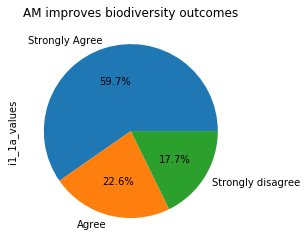

In [3]:
clean_df['i1_1a_values'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='AM improves biodiversity outcomes')

In [4]:
n = clean_df['i1_1a'].count()
i = clean_df['i1_1a'].mean()
print(f'n: {n}, {i: .2%}')

n: 62,  82.26%


### Indicator 1.1b
**Shared understanding of the tools and practices recommended for AM in biodiversity programming converted to a 5-point scale.**					
This sub-indicator is calculated as the percentage of respondents that agrees or strongly agrees that the use of the four AM practices identified in the survey are important or very important in biodiverisity programming.					
*Note: if the respondent does not respond to any of the 4 prompts, they are excluded.*

In [5]:
response_count = clean_df[['PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].apply(pd.Series.value_counts, axis=1)
clean_df['i1_1b_values'] = response_count[['Important', 'Very important']].sum(axis=1)
clean_df['i1_1b'] = clean_df['i1_1b_values'] == 4
# overwrite with na if any responses are missing
filt = clean_df[['PR5-5', 'PR6-5', 'PR7-4', 'PR8-5']].isna().any(axis=1)
clean_df['i1_1b'] = clean_df['i1_1b'].mask(filt, np.nan)

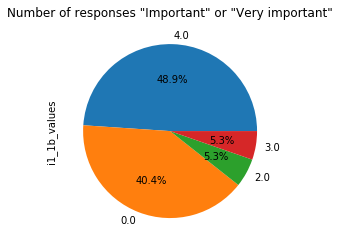

In [6]:
clean_df['i1_1b_values'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Number of responses "Important" or "Very important"')

In [7]:
n = clean_df['i1_1b'].count()
i = clean_df['i1_1b'].mean()
print(f'n: {n}, {i: .2%}')

n: 55,  83.64%


## Indicator 1.1c
**Commitment to resourcing AM in biodiveristy programming**				
This sub-indicator is calculated as the percentage of respondents that agrees or strongly agrees that environment teams have access to the resources needed to adaptively manage their programs converted to a 5-point scale.					


In [8]:
clean_df['i1_1c_values'] = coded_df[['AM4-2', 'AM12-2']]\
    .apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)\
    .replace(r'^\s*$', np.nan, regex=True)
clean_df['i1_1c'] = clean_df['i1_1c_values'].isin(['Strongly Agree', 'Agree'])
# overwrite null values
filt = clean_df['i1_1c_values'].isna()
clean_df['i1_1c'] = clean_df['i1_1c'].mask(filt, np.nan)

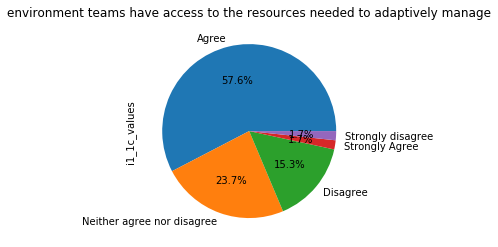

In [9]:
clean_df['i1_1c_values'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='environment teams have access to the resources needed to adaptively manage')

In [10]:
n = clean_df['i1_1c'].count()
i = clean_df['i1_1c'].mean()
print(f'n: {n}, {i: .2%}')

n: 59,  59.32%


## Indicator 1.1
**Sector-wide shared understanding index**				
This is a composite indicator calculated as the sum of three sub-indicators associated with a shared understanding of AM (range 3-15).					


In [11]:
bins = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
labels = [1, 2, 3, 4, 5]
means_1_1 = clean_df[['i1_1a', 'i1_1b', 'i1_1c']].mean()
scores_1_1 = pd.cut(means_1_1, bins=bins, labels=labels, right=False)  # right exclusive
i1_1 = scores_1_1.astype(int).sum()
print(f'Indicator 1.1 = {i1_1}')

Indicator 1.1 = 13


## Indicator 4.1
**Percentage of respondents reporting that enabling conditions for EBP are in place**				
This indicator is calculated as the percentage of respondents assigning scores of 4 or 5 to both EBP enabling conditions identified in the survey. The sample only includes respondents who assessed both EBP enabling conditions.					


In [12]:
agree_list = ['Agree', 'Strongly Agree']
filt = (clean_df['EV1-5'].isin(agree_list) | clean_df['EV3-4'].isin(agree_list))\
    & (clean_df['EV2-4'].isin(agree_list) | clean_df['EV4-4'].isin(agree_list))
clean_df['i4_1'] = filt
# overwrite with na if any responses are missing
filt = (clean_df[['EV1-5', 'EV3-4']].isna().all(axis=1)) \
    & (clean_df[['EV2-4', 'EV4-4']].isna().all(axis=1))
clean_df['i4_1'] = clean_df['i4_1'].mask(filt, np.nan)

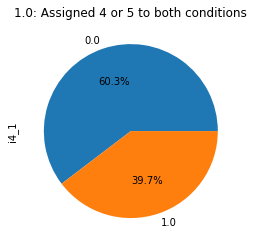

In [13]:
clean_df['i4_1'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='1.0: Assigned 4 or 5 to both conditions')

In [14]:
n = clean_df['i4_1'].count()
i = clean_df['i4_1'].mean()
print(f'n: {n}, {i: .2%}')

n: 58,  39.66%


## Indicator 5.1
**Percentage of respondents reporting broad uptake of AM practices in biodiversity programming**			
This indicator is calculated as the percentage of respondents reporting a high level of use across all four practices identified in the survey. The sample only includes respondents who assessed all four practices.

In [15]:
response_count = clean_df[['PR1-5', 'PR2-4', 'PR3-4', 'PR4-3']].apply(pd.Series.value_counts, axis=1)
clean_df['i5_1_values'] = response_count[['Agree', 'Strongly Agree']].sum(axis=1)
clean_df['i5_1'] = clean_df['i5_1_values'] == 4

# overwrite with na if any responses are missing
filt = clean_df[['PR1-5', 'PR2-4', 'PR3-4', 'PR4-3']].isna().any(axis=1)
clean_df['i5_1'] = clean_df['i5_1'].mask(filt, np.nan)

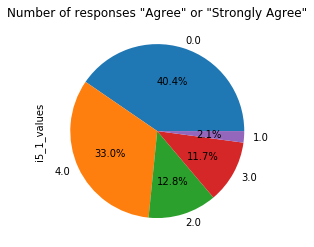

In [16]:
clean_df['i5_1_values'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Number of responses "Agree" or "Strongly Agree"')

In [17]:
n = clean_df['i5_1'].count()
i = clean_df['i5_1'].mean()
print(f'n: {n}, {i: .2%}')

n: 55,  56.36%


## Indicator 6.1
**Percentage of respondents reporting that application of MI/MI2 practices had a positive effect on Program Cycle outputs**				
This indicator is calculated as the percentage of respondents reporting that MI/MI2 practices had a moderate or strong poistive effect on the Program Cycle output for which they received techncial assistance. The sample excludes respondents who received TA but reported that they did not know the effect of MI/MI2 practices on the Program Cycle output.

In [18]:
clean_df['i6_1_values'] = clean_df[['MI6.1-3', 'MI6.2-3', 'MI6.3-3', 'MI6.4-3', 'MI6.5-3', 'MI6.6-3', 'MI6.7-1']].apply(lambda x: ''.join(x.dropna().astype(str)), axis=1)\
    .replace(r'^\s*$', np.nan, regex=True)
clean_df['i6_1'] = clean_df['i6_1_values'].str.contains('positive').astype(float)
# mask instances of 'I don't know' note unicode character for apostrophe
mask = clean_df['i6_1_values']=='I don’t know'
clean_df['i6_1'] = clean_df['i6_1'].mask(mask, np.nan)

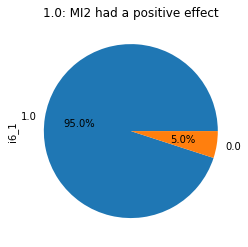

In [19]:
clean_df['i6_1'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='1.0: MI2 had a positive effect')

In [20]:
n = clean_df['i6_1'].count()
i = clean_df['i6_1'].mean()
print(f'n: {n}, {i: .2%}')

n: 40,  95.00%


In [21]:
clean_df.to_csv('clean_df.csv')